### Import

In [2]:
from qutip import *
from qutip.operators import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from cython import *
from sympy import lambdify

### Parameters

In [4]:
N = 5                  # number of states in charge basis: -N...N
ν_ge = 6.0             # atom frequency, GHz
Ec = 0.2
Ej = (ν_ge-Ec)**2/Ec/8  # see Koch's paper for the approximation of the ge transition frequency
dEj = 0.2               #Ej(t) = Ej*time_coeff(t,dEj)
a = 33                  #approximate start of Ej change
b = 66                 #approximate end of Ej change
st = 1            #st -> 0, time_coeff -> theta(t-a) - theta(t-b)
time_coeff = "1-E*(tanh((t-a)/st) - tanh((t-b)/st))"
args = {'a':a,'b':b,'st':st,'E':dEj}
tlist = np.linspace(0,120,400)
gamma_m = 0.001          #collapse rate

#psi0                    #-> evecs[0]

### Visualize pulse

/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


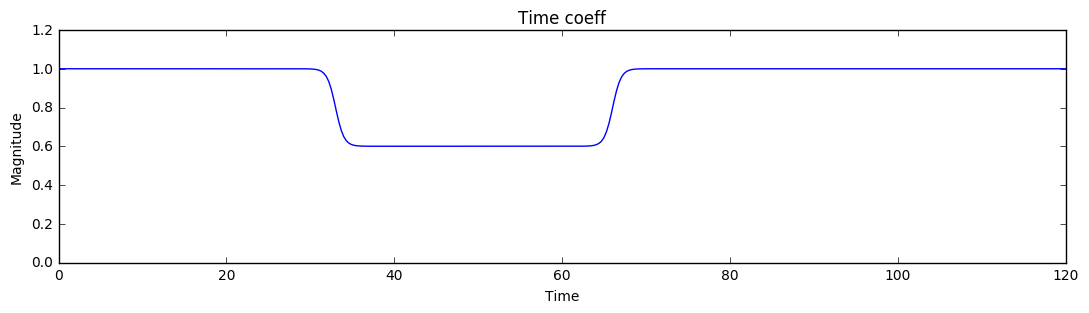

In [5]:
time_c_func = lambdify({'a','b','st','E','t'},time_coeff,'numpy')
fig, ax = plt.subplots(1,1, figsize=(13,3))
ax.set_title('Time coeff');
ax.plot(tlist, time_c_func(a=a,b=b,E=dEj,st=st,t=tlist))
ax.set_ylim(0,1.2)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude');

### Operators

In [6]:
def n(N_states):
    return num(2*N_states+1, offset = -N_states)

def Hc(N_states = N, n_g = 0, Ec = Ec):
    return 4*Ec*(n(N_states)-n_g)**2

def Hj(N_states = N, Ej = Ej):
    return -0.5*Ej*Qobj(np.diag(np.ones(2*N_states), -1)+np.diag(np.ones(2*N_states), 1))

def Hq(N_states = N, Ej = Ej, Ec = Ec):
    return Hc(N_states,Ec) + Hj(N_states,Ej)

def Hq_t(N_states = N,time_coeff = time_coeff, Ej = Ej, Ec = Ec):
    return [Hc(N_states, Ec),[Hj(N_states,Ej), time_coeff]]

evals, evecs = Hq().eigenstates()
psi0 = evecs[0]

def c(N_states=N,evecs=evecs, Ej = Ej, Ec = Ec):
    return sum([n(N).matrix_element(evecs[j], evecs[j+1])/n(N).matrix_element(evecs[0], evecs[1])\
                    * evecs[j]*evecs[j+1].dag() for j in range(0, len(evecs)-1)])

def collapse_list(N_states = N,gamma_m = gamma_m):
    collapse_list = []
    collapse_list.append(np.sqrt(gamma_m) * c())
    return collapse_list

### Dynamics (sample)

In [7]:
expected = [Hq()]
def solve(expected_ops = expected, with_progress_bar = True):
    if with_progress_bar:
        return mesolve(Hq_t(), psi0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=10000), progress_bar=True)
    else:
        return mesolve(Hq_t(), psi0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=10000))

In [8]:
expected = [Hq()]
for i in range(len(evecs)):
    expected.append(evecs[i]*evecs[i].dag())
    
output = solve(expected)

10.0%. Run time:   0.01s. Est. time left: 00:00:00:00
20.0%. Run time:   0.08s. Est. time left: 00:00:00:00
30.0%. Run time:   0.17s. Est. time left: 00:00:00:00
40.0%. Run time:   0.30s. Est. time left: 00:00:00:00
50.0%. Run time:   0.49s. Est. time left: 00:00:00:00
60.0%. Run time:   0.72s. Est. time left: 00:00:00:00
70.0%. Run time:   1.05s. Est. time left: 00:00:00:00
80.0%. Run time:   1.37s. Est. time left: 00:00:00:00
90.0%. Run time:   1.69s. Est. time left: 00:00:00:00
Total run time:   1.98s


### Visual

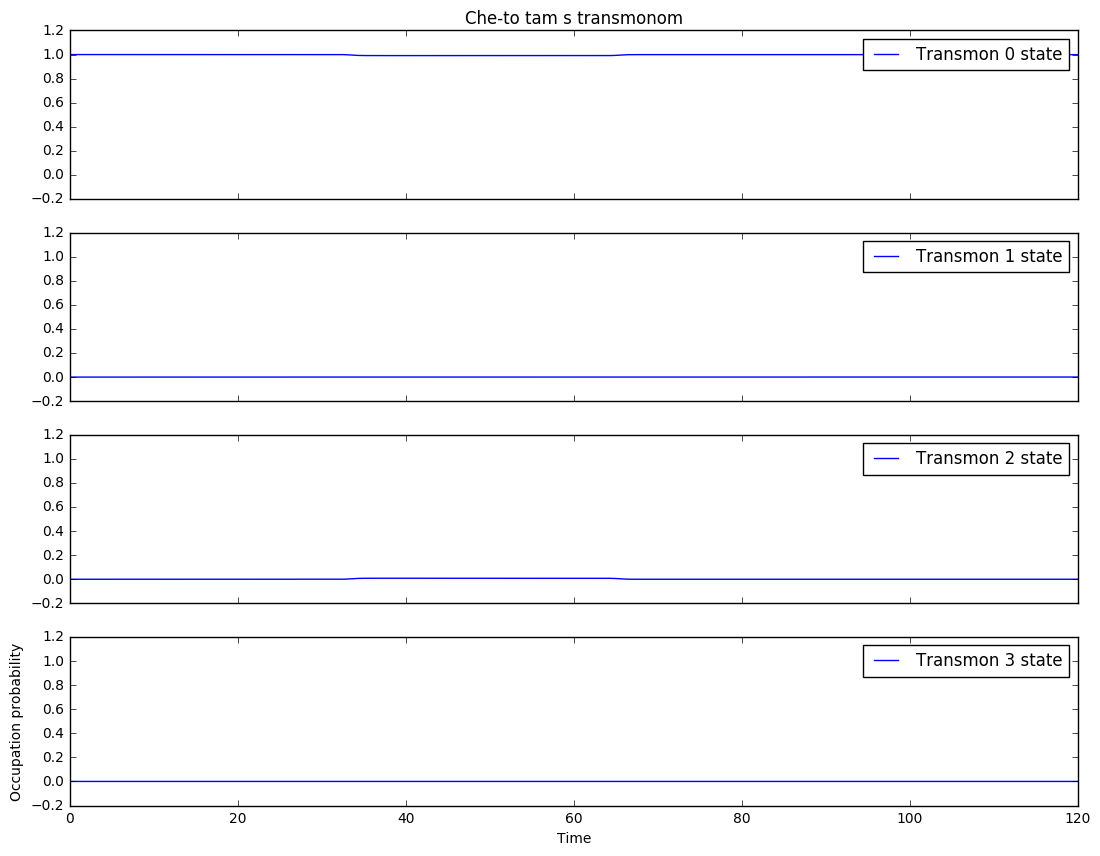

In [9]:
fig, axes = plt.subplots(4,1, figsize=(13,10), sharex=True)
axes[0].set_title('Che-to tam s transmonom');
for idx, ax in enumerate(axes):
    ax.plot(tlist, output.expect[1+idx], label="Transmon %i state"%idx)
    ax.set_ylim(-0.2,1.2)
    ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Occupation probability')

### Dynamics (series for dEj)

In [27]:
%%time
start_dEj = 0.4
end_dEj   = 0.5
steps_dEj = 10
tlist = np.linspace(0,200,400)
output = []
expected = [evecs[0]*evecs[0].dag()]
for dEj_id, dEj in enumerate(np.linspace(start_dEj, end_dEj, steps_dEj)):
    args['E'] = dEj
    output.append([solve(expected, False).expect[0],dEj])
    print('solved %d of %d\n' % (dEj_id+1,steps_dEj))

    

solved 1 of 10

solved 2 of 10

solved 3 of 10

solved 4 of 10

solved 5 of 10

solved 6 of 10

solved 7 of 10

solved 8 of 10

solved 9 of 10

solved 10 of 10

CPU times: user 36.7 s, sys: 424 ms, total: 37.1 s
Wall time: 59.2 s


### Visual

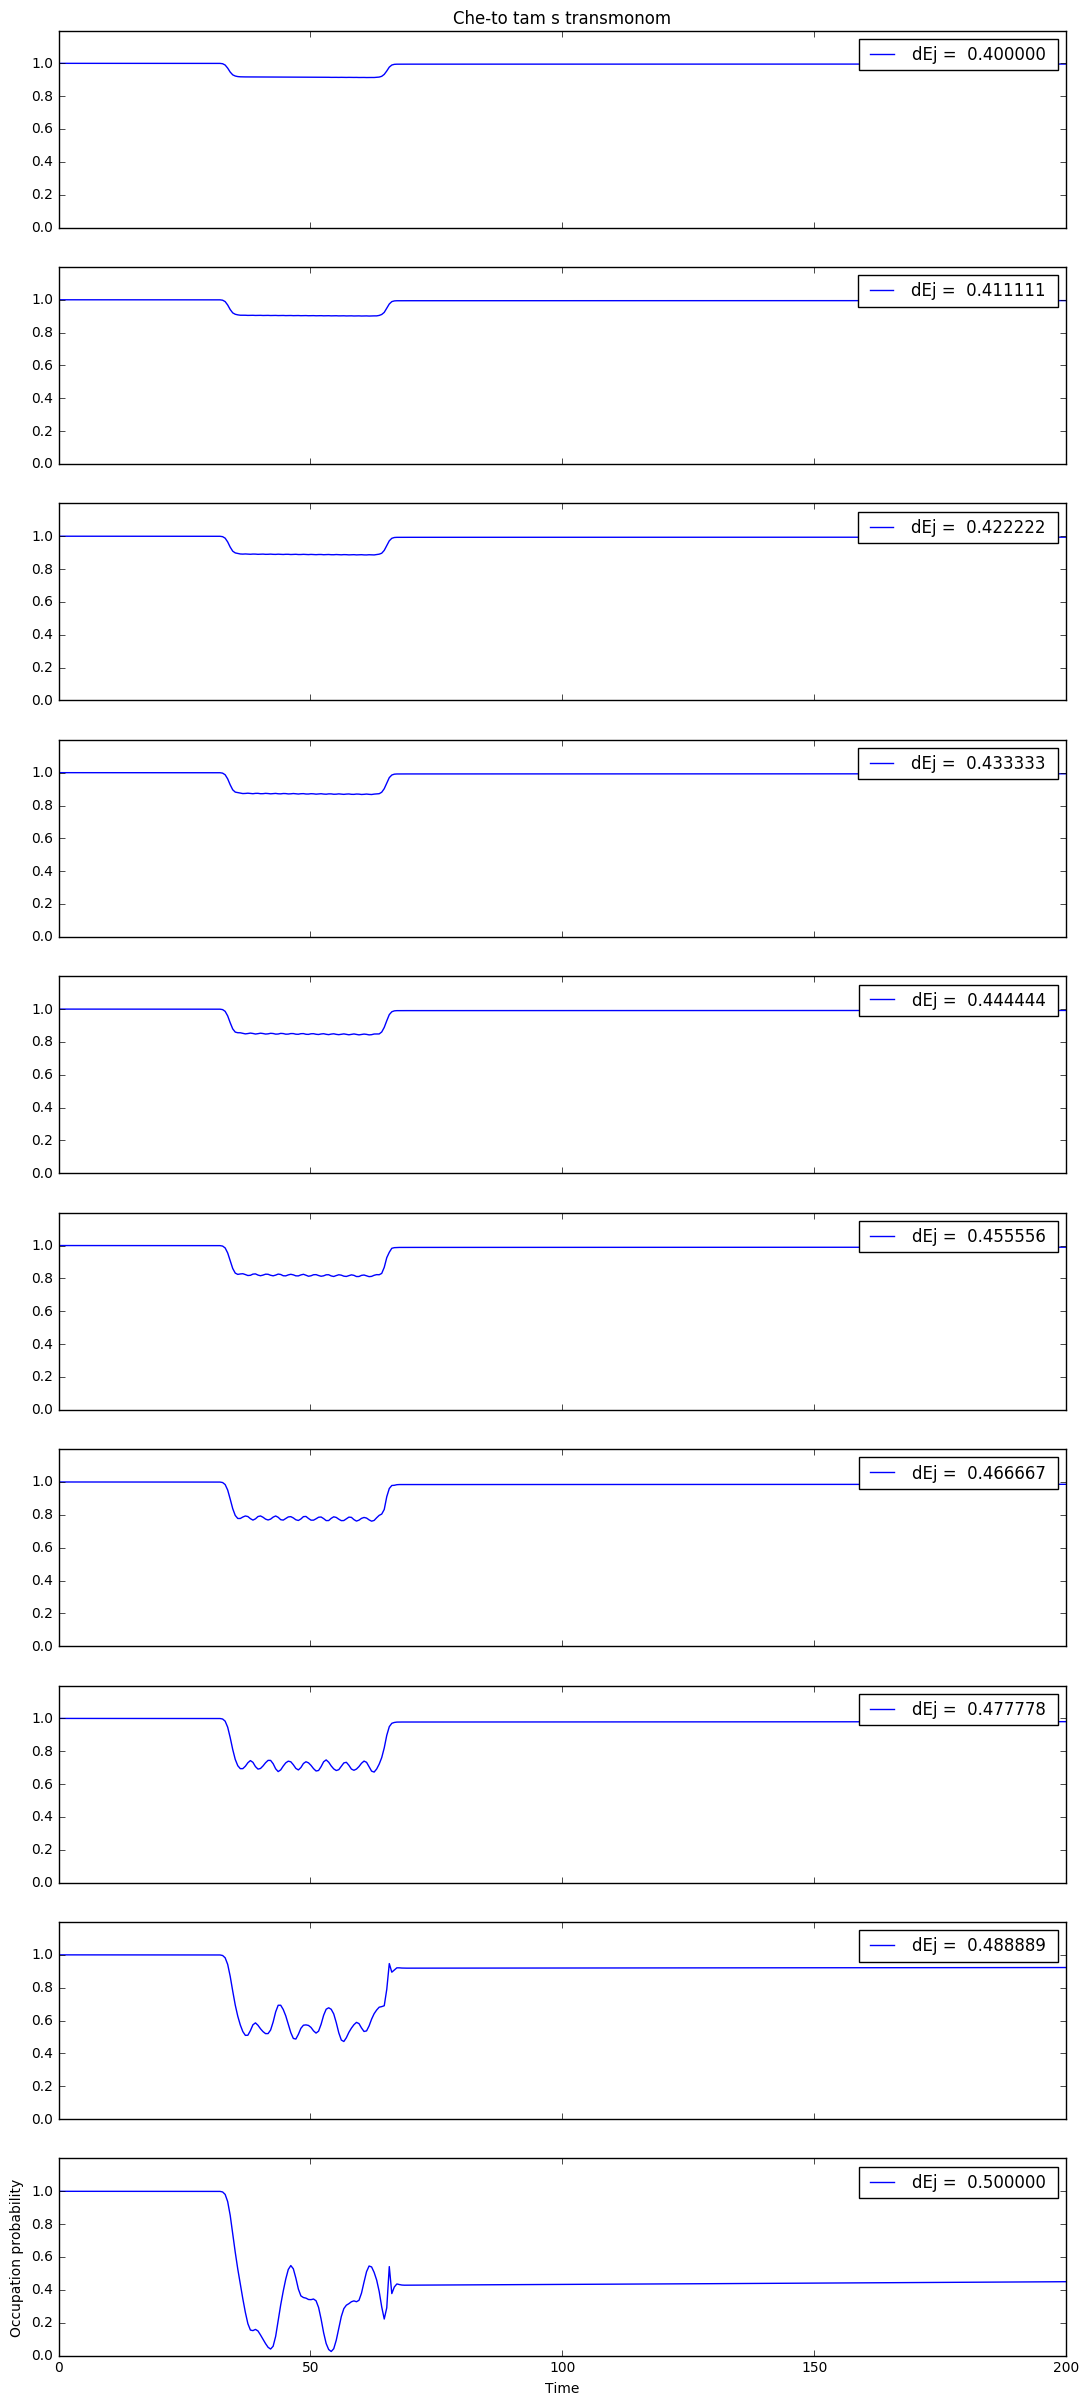

In [28]:
graphs = steps_dEj
maxgraphs = graphs
fig, axes = plt.subplots(graphs,1, figsize=(13,3*graphs), sharex=True)
axes[0].set_title('Che-to tam s transmonom');
for idx, ax in enumerate(axes):
    time_out, dEj = output[idx]
    ax.plot(tlist, time_out, label="dEj =  %f "%dEj)
    ax.set_ylim(0,1.2)
    ax.legend()
    if idx >= maxgraphs:
        break
ax.set_xlabel('Time')
ax.set_ylabel('Occupation probability')

### Dynamics (series for b)

In [31]:
%%time
start_b = 66
end_b   = 68
steps_b = 10
tlist = np.linspace(0,200,400)
output = []
expected = [evecs[0]*evecs[0].dag()]
b_list = np.linspace(start_b, end_b, steps_b)
dEj = 0.47
for b_id, b_tmp in enumerate(b_list):
    args['b'] = b_tmp
    args['E'] = dEj
    output.append([solve(expected, False).expect[0],b_tmp])
    print('solved %d of %d\n' % (b_id+1,steps_b))

solved 1 of 10

solved 2 of 10

solved 3 of 10

solved 4 of 10

solved 5 of 10

solved 6 of 10

solved 7 of 10

solved 8 of 10

solved 9 of 10

solved 10 of 10

CPU times: user 28.9 s, sys: 380 ms, total: 29.3 s
Wall time: 51 s


### Visual

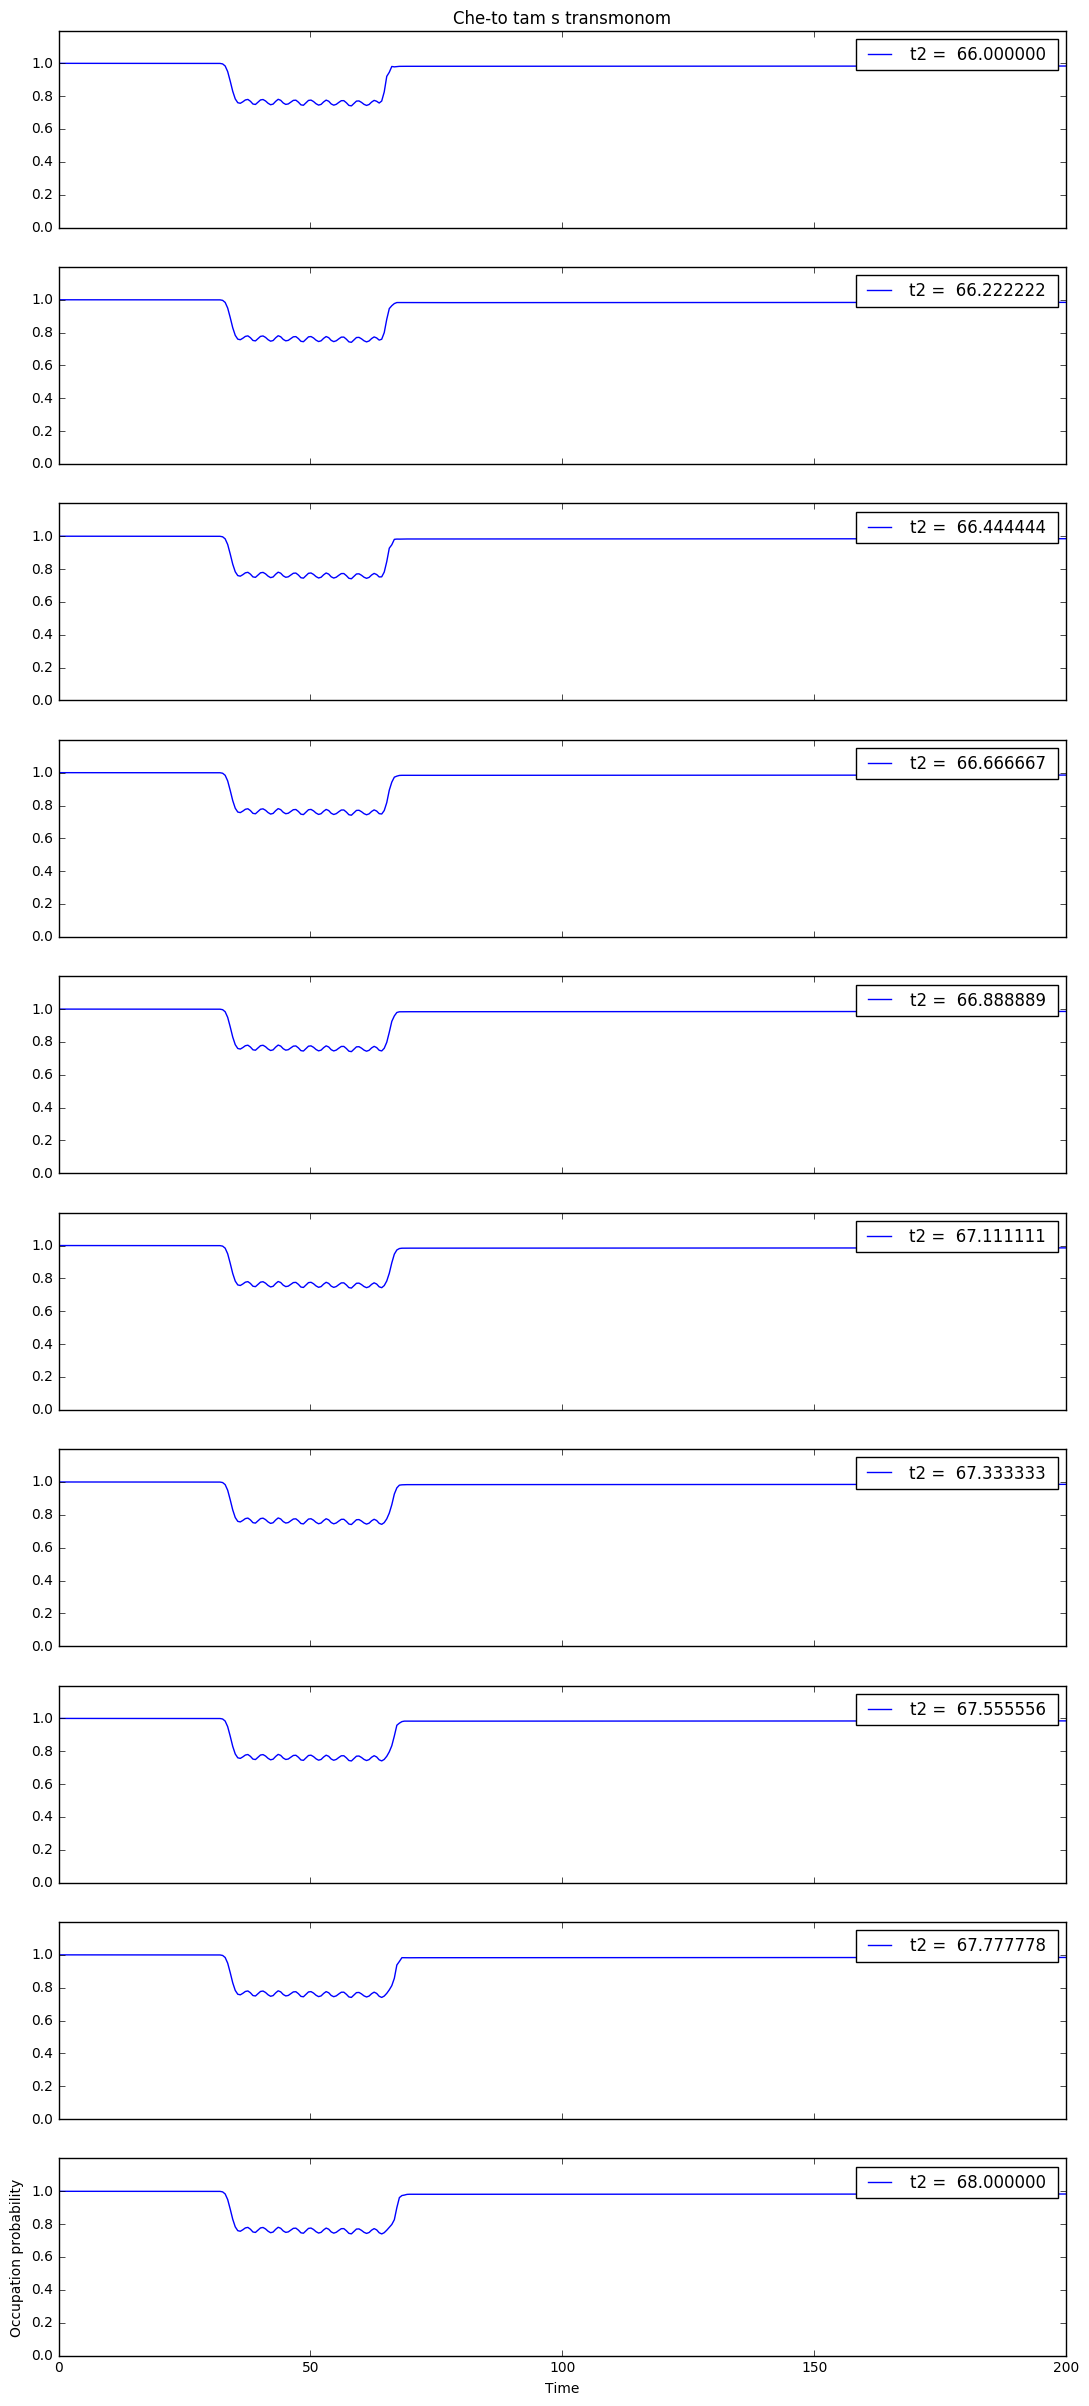

In [32]:
graphs = steps_b
maxgraphs = graphs
fig, axes = plt.subplots(graphs,1, figsize=(13,3*graphs), sharex=True)
axes[0].set_title('Che-to tam s transmonom');
for idx, ax in enumerate(axes):
    time_out, b = output[idx]
    ax.plot(tlist, time_out, label="b =  %f "%b)
    ax.set_ylim(0,1.2)
    ax.legend()
    if idx >= maxgraphs:
        break
ax.set_xlabel('Time')
ax.set_ylabel('Occupation probability')

### Ground state occupation(+inf) <- dEj ?

In [33]:
def compressed_check(cont, every_percent):
    step = 1
    while True:
        yield step*len(cont)/100.0*every_percent
        step = step + 1

In [34]:
%%time
start_dEj = 0.00
end_dEj   = 0.99
steps_dEj = 100
dEj_list = np.linspace(start_dEj, end_dEj, steps_dEj)
tlist = np.linspace(0,200,40)
output = []
expected = [evecs[0]*evecs[0].dag()]
check = compressed_check(dEj_list,10)
print_id = next(check)
for dEj_id, dEj in enumerate(dEj_list):
    args['E'] = dEj
    output.append(solve(expected, False).expect[0])
    if(dEj_id+1 >= print_id):
        print('solved %d of %d\n' % (dEj_id+1,steps_dEj))
        print_id = next(check)
    

solved 10 of 100

solved 20 of 100

solved 30 of 100

solved 40 of 100

solved 50 of 100

solved 60 of 100

solved 70 of 100

solved 80 of 100

solved 90 of 100

solved 100 of 100

CPU times: user 6min 12s, sys: 5 s, total: 6min 17s
Wall time: 9min 59s


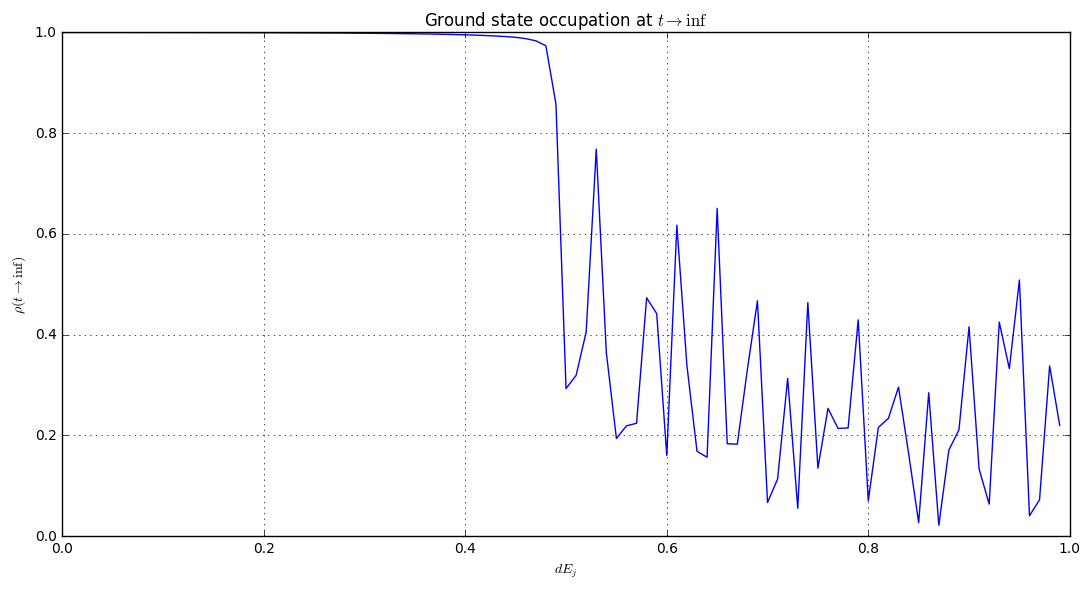

In [35]:
rho = list(map(lambda l:l[-1],output))
fig = plt.figure(figsize=(13,6.5),dpi=300)
dep = fig.add_subplot(1,1,1)
dep.set_title(r'Ground state occupation at $t \rightarrow \inf$')
dep.set_xlabel(r'$dE_j$')
dep.set_ylabel(r'$\rho(t \rightarrow \inf)$')
dep.plot(dEj_list,rho)
dep.grid()
#this is for b-a = const !